In [6]:
import numpy as np
import torch

def get_logits_from_logistic_pars(loc, log_scale, num_classes = 10):
    loc = loc.unsqueeze(-1)
    log_scale = log_scale.unsqueeze(-1)

    inv_scale = (-log_scale + 2.0).exp()
    
    bin_width = 2.0 / (num_classes - 1)
    bin_centers = torch.linspace(-1.0, 1.0, num_classes).to(loc.device)
    bin_centers = bin_centers.reshape((*loc.shape, num_classes))
    bin_centers = bin_centers - loc
    log_cdf_min = -torch.log1p((-inv_scale * (bin_centers - 0.5 * bin_width)).exp())
    log_cdf_plus = -torch.log1p((-inv_scale * (bin_centers + 0.5 * bin_width)).exp())
    logits = log_minus_exp(log_cdf_plus, log_cdf_min)
    return logits

def log_minus_exp(a, b, epsilon=1.e-6):
    return a + torch.log1p(-torch.exp(b - a) + epsilon)





loc = torch.randn(1, 1, 1, 1).clip(-1, 1)
log_scale = torch.randn(1, 1, 1, 1)

num_classes = 10
logits = get_logits_from_logistic_pars(loc, log_scale, num_classes)




In [7]:
logits[0,0,0,0,:]

tensor([[-1.4609, -1.4102, -1.8315, -2.5864, -3.5119, -4.5085, -5.5319, -6.5647,
         -7.6002, -8.6343]])

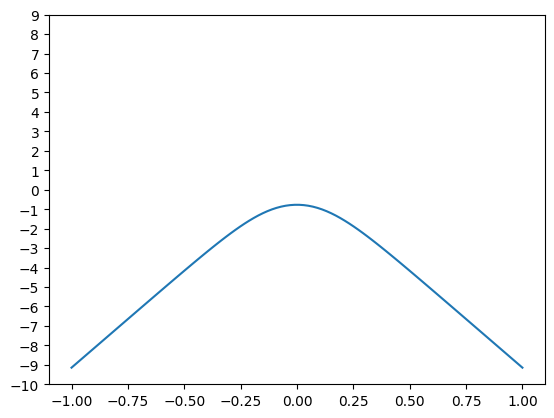

In [8]:
# log(1/(1 + exp(-x - eps) - 1/(1 + exp(-x + eps)))
# plot 
inv_scale = 10
f = lambda x : np.log(1/(1 + np.exp(- inv_scale * (x  + 0.1))) - 1/(1 + np.exp(- inv_scale* (x  - 0.1))))

import matplotlib.pyplot as plt
import numpy as np
x = np.linspace(-1, 1, 100)
y = f(x)
plt.plot(x, y)
plt.yticks(np.arange(-10, 10, 1))
plt.show()

In [9]:
num_classes = 10
beta = 0.1
mat = torch.ones(num_classes, num_classes) * beta / num_classes
# diagonal is 1 - (K - 1)/K * beta
mat.diagonal().fill_(1 - (num_classes - 1) * beta / num_classes)

tensor([0.9100, 0.9100, 0.9100, 0.9100, 0.9100, 0.9100, 0.9100, 0.9100, 0.9100,
        0.9100])

In [10]:
mat

tensor([[0.9100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
         0.0100],
        [0.0100, 0.9100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
         0.0100],
        [0.0100, 0.0100, 0.9100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
         0.0100],
        [0.0100, 0.0100, 0.0100, 0.9100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
         0.0100],
        [0.0100, 0.0100, 0.0100, 0.0100, 0.9100, 0.0100, 0.0100, 0.0100, 0.0100,
         0.0100],
        [0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.9100, 0.0100, 0.0100, 0.0100,
         0.0100],
        [0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.9100, 0.0100, 0.0100,
         0.0100],
        [0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.9100, 0.0100,
         0.0100],
        [0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.9100,
         0.0100],
        [0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
         0.9100]])

In [1]:
from typing import Dict, Tuple
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from tqdm import tqdm
from torchvision.datasets import MNIST
from torchvision import transforms
from torchvision.utils import save_image, make_grid


blk = lambda ic, oc: nn.Sequential(
    nn.Conv2d(ic, oc, 7, padding=3),
    nn.GroupNorm(oc // 8, oc, affine = False, eps = 1e-4),
    nn.LeakyReLU(),
)


class DummyX0Model(nn.Module):
    """
    This should be unet-like, but let's don't think about the model too much :P
    Basically, any universal R^n -> R^n model should work.
    """

    def __init__(self, n_channel: int, N) -> None:
        super(DummyX0Model, self).__init__()
        self.start =  blk(n_channel, 16)
        self.pe = nn.Parameter(torch.randn(1, 16, 32, 32))
        self.conv = nn.Sequential(
            blk(16, 128),
            blk(128, 256),
            blk(256, 512),
            blk(512, 256),
            blk(256, 128),
            blk(128, 64),
            nn.Conv2d(64, 2 * n_channel, 3, padding=1),
        )
        self.N = N

    def forward(self, x, t) -> torch.Tensor:
        # Lets think about using t later. In the paper, they used Tr-like positional embeddings.
        st = x.float() / self.N - 0.5
        x = self.start(st) + self.pe
        y = self.conv(x)
        loc, log_scale = y.chunk(2, dim=1)

        return torch.tanh(loc + st), log_scale

# blk = lambda ic, oc: nn.Sequential(
#     nn.Conv2d(ic, oc, 5, padding=2),
#     nn.GroupNorm(oc // 8, oc),
#     nn.LeakyReLU(),
#     nn.Conv2d(oc, oc, 5, padding=2),
#     nn.GroupNorm(oc // 8, oc),
#     nn.LeakyReLU(),
#     nn.Conv2d(oc, oc, 5, padding=2),
#     nn.GroupNorm(oc // 8, oc),
#     nn.LeakyReLU(),
# )

# blku = lambda ic, oc: nn.Sequential(
#     nn.Conv2d(ic, oc, 5, padding=2),
#     nn.GroupNorm(oc // 8, oc),
#     nn.LeakyReLU(),
#     nn.Conv2d(oc, oc, 5, padding=2),
#     nn.GroupNorm(oc // 8, oc),
#     nn.LeakyReLU(),
#     nn.Conv2d(oc, oc, 5, padding=2),
#     nn.GroupNorm(oc // 8, oc),
#     nn.LeakyReLU(),
#     nn.ConvTranspose2d(oc, oc, 2, stride=2),
#     nn.GroupNorm(oc // 8, oc),
#     nn.LeakyReLU(),
    
# )

# class DummyX0Model(nn.Module):
    

    # def __init__(self, n_channel: int, N : int = 16) -> None:
    #     super(DummyX0Model, self).__init__()
    #     self.down1 = blk(n_channel, 16)
    #     self.down2 = blk(16, 32)
    #     self.down3 = blk(32, 64)
    #     self.down4 = blk(64, 512)
    #     self.down5 = blk(512, 512)
    #     self.up1 = blku(512, 512)
    #     self.up2 = blku(512 + 512, 64)  # Corrected to account for concatenated feature maps
    #     self.up3 = blku(64 + 64, 32)    # Corrected to account for concatenated feature maps
    #     self.up4 = blku(32 + 32, 16)    # Corrected to account for concatenated feature maps
    #     self.convlast = blk(32, 16)
    #     self.final = nn.Conv2d(16, 2 * n_channel, 1)

    #     # initialize final with zero
    #     self.final.weight.data.zero_()
    #     self.final.bias.data.zero_()

    #     self.tr1 = nn.TransformerEncoderLayer(d_model=512, nhead=8)
    #     self.tr2 = nn.TransformerEncoderLayer(d_model=512, nhead=8)
    #     self.tr3 = nn.TransformerEncoderLayer(d_model=64, nhead=8)

    #     self.temb_1 = nn.Linear(32, 16)
    #     self.temb_2 = nn.Linear(32, 32)
    #     self.temb_3 = nn.Linear(32, 64)
    #     self.temb_4 = nn.Linear(32, 512)
    #     self.N = N

    # def forward(self, x, t) -> torch.Tensor:
    #     x = (2 * x.float() / self.N) - 1.0
    #     t = t.float().reshape(-1, 1) / 10000
    #     t_as_sin = [torch.sin(t * 3.1415 * 2 ** i) for i in range(16)]
    #     t_as_cos = [torch.cos(t * 3.1415 * 2 ** i) for i in range(16)]
    #     # concat and send it to t_emb
    #     t_emb_1 = self.temb_1(torch.cat(t_as_sin + t_as_cos, dim=1).to(x.device)).reshape(x.shape[0], -1, 1, 1)
    #     t_emb_2 = self.temb_2(torch.cat(t_as_sin + t_as_cos, dim=1).to(x.device)).reshape(x.shape[0], -1, 1, 1)
    #     t_emb_3 = self.temb_3(torch.cat(t_as_sin + t_as_cos, dim=1).to(x.device)).reshape(x.shape[0], -1, 1, 1)
    #     t_emb_4 = self.temb_4(torch.cat(t_as_sin + t_as_cos, dim=1).to(x.device)).reshape(x.shape[0], -1, 1, 1)
        
    #     x1 = self.down1(x) + t_emb_1
    #     x2 = self.down2(nn.functional.avg_pool2d(x1, 2)) + t_emb_2
    #     x3 = self.down3(nn.functional.avg_pool2d(x2, 2)) + t_emb_3
    #     x4 = self.down4(nn.functional.avg_pool2d(x3, 2)) + t_emb_4
    #     x5 = self.down5(nn.functional.avg_pool2d(x4, 2))

    #     x5 = self.tr1(x5.reshape(x5.shape[0], x5.shape[1], -1).transpose(1, 2)).transpose(1, 2).reshape(x5.shape)

    #     y = self.up1(x5)

    #     y = self.tr2(y.reshape(y.shape[0], y.shape[1], -1).transpose(1, 2)).transpose(1, 2).reshape(y.shape)
  
    #     y = self.up2(torch.cat([x4, y], dim=1))

    #     y = self.tr3(y.reshape(y.shape[0], y.shape[1], -1).transpose(1, 2)).transpose(1, 2).reshape(y.shape)

    #     y = self.up3(torch.cat([x3, y], dim=1))

    #     y = self.up4(torch.cat([x2, y], dim=1))


    #     y = self.convlast(torch.cat([x1, y], dim=1))
    #     y = self.final(y)
    #     loc, log_scale = y.chunk(2, dim=1)

    #     return torch.tanh(loc + x), log_scale


# check if it takes 2, 1, 28, 28 input

model = DummyX0Model(1, N = 16)
model(torch.randn(2, 1, 32, 32), torch.tensor([1, 2]))[0].shape



def get_logits_from_logistic_pars(loc, log_scale, num_classes = 10):
    loc = loc.unsqueeze(-1)
    log_scale = log_scale.unsqueeze(-1)
    inv_scale = (-log_scale + 2.0).exp()

    bin_width = 2.0 / (num_classes - 1)
    bin_centers = torch.linspace(-1.0, 1.0, num_classes).to(loc.device)
    bin_centers = bin_centers.reshape([1] * (len(loc.shape) - 1) + [num_classes])
    bin_centers = bin_centers - loc
    log_cdf_min = -torch.log1p((-inv_scale * (bin_centers - 0.5 * bin_width)).exp())
    log_cdf_plus = -torch.log1p((-inv_scale * (bin_centers + 0.5 * bin_width)).exp())
    logits = log_minus_exp(log_cdf_plus, log_cdf_min)
    return logits


def log_minus_exp(a, b, epsilon=1e-6):
    return a + torch.log1p(-torch.exp(b - a) + epsilon)



class D3PM(nn.Module):
    def __init__(
        self,
        x0_model: nn.Module,
        n_T: int,
        num_classes: int = 10,
        forward_type = 'uniform',
        hybrid_loss_coeff = 0.001
    ) -> None:
        super(D3PM, self).__init__()
        self.x0_model = x0_model

        self.n_T = n_T
        self.hybrid_loss_coeff = hybrid_loss_coeff
        self.beta_t = [1 / (self.n_T - t + 1) for t in range(1, self.n_T + 1)]
        self.eps = 1e-8
        self.num_classses = num_classes
        q_onestep_mats = []
        q_mats = [] # these are cumulative

        for beta in self.beta_t:

            if forward_type == 'uniform':
                mat = torch.ones(num_classes, num_classes) * beta / num_classes
                mat.diagonal().fill_(1 - (num_classes - 1) * beta / num_classes)
                q_onestep_mats.append(mat)
            else:
                raise NotImplementedError
        q_one_step_mats = torch.stack(q_onestep_mats, dim=0)

        q_one_step_transposed = q_one_step_mats.transpose(1, 2) # this will be used for q_posterior_logits

        q_mat_t = q_onestep_mats[0]
        q_mats = [q_mat_t]
        for idx in range(1, self.n_T):
            q_mat_t = q_mat_t @ q_onestep_mats[idx]
            q_mats.append(q_mat_t)
        q_mats = torch.stack(q_mats, dim=0)

        # register
        self.register_buffer("q_one_step_transposed", q_one_step_transposed)
        self.register_buffer("q_mats", q_mats)

        assert self.q_mats.shape == (self.n_T, num_classes, num_classes), self.q_mats.shape
    
    def _at(self, a, t, x):
        # t is 1-d, x is integer value of 0 to num_classes - 1
        bs = t.shape[0]
        t = t.reshape((bs, *[1] * (x.dim() - 1)))
        #out[i, j, k, l, m] = a[t[i, j, k, l], x[i, j, k, l], m]
        return a[t - 1, x, :]


    def q_posterior_logits(self, x_0, x_t, t):
        # if t == 1, this means we return the L_0 loss, so directly try to x_0 logits.
        # otherwise, we return the L_{t-1} loss.
        # Also, we never have t == 0.

        # if x_0 is integer, we convert it to one-hot.
        if x_0.dtype == torch.int64 or x_0.dtype == torch.int32:
            x_0_logits = torch.log(torch.nn.functional.one_hot(x_0, self.num_classses) + self.eps)
        else:
            x_0_logits = x_0.clone()

        assert x_0_logits.shape == x_t.shape + (self.num_classses,), print(f"x_0_logits.shape: {x_0_logits.shape}, x_t.shape: {x_t.shape}")

        # Here, we caclulate equation (3) of the paper. Note that the x_0 Q_t x_t^T is a normalizing constant, so we don't deal with that.
        # fact1 is "guess of x_{t-1}" from x_t
        # fact2 is "guess of x_{t-1}" from x_0

        fact1 = self._at(self.q_one_step_transposed, t, x_t)
        #fact2 = self._at_onehot(self.q_mats, t-1, )
        # x, a[t-1]


        softmaxed = torch.softmax(x_0_logits, dim=-1) # bs, ..., num_classes
        qmats2 = self.q_mats[t-2] # bs, num_classes, num_classes

        fact2 = torch.einsum('b...c,bcd->b...d', softmaxed, qmats2)
    
        #print(f"Fact1Fact2", fact1.shape, fact2.shape)
        out = torch.log(fact1 + self.eps) + torch.log(fact2 + self.eps)
        #print(f"out: {out.shape}")
        t_broadcast = t.reshape((t.shape[0], *[1] * (x_t.dim())))
        #print(t_broadcast.shape)
        bc = torch.where(t_broadcast == 1, x_0_logits, out)
        #print(f"bc: {bc.shape}")
        return bc

    def vb(self, dist1, dist2):
        out = (torch.softmax(dist1 + self.eps, dim = -1)*(torch.log_softmax(dist1 + self.eps, dim = -1) - torch.log_softmax(dist2 + self.eps, dim = -1)))
        return out.sum(dim=-1).mean()

        
    def q_sample(self, x_0, t, noise):
        # forward process, x_0 is the clean input.
        
        logits = torch.log(self._at(self.q_mats, t, x_0) + self.eps)
        noise = torch.clip(noise, self.eps, 1.0)
        gumbel_noise = -torch.log(-torch.log(noise))
        return torch.argmax(logits + gumbel_noise, dim=-1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Makes forward diffusion x_t from x_0, and tries to guess x_0 value from x_t using x0_model.
        x is one-hot of dim (bs, ...), with int values of 0 to num_classes - 1
        """
        t = torch.randint(1, self.n_T, (x.shape[0],), device=x.device)
        x_t = self.q_sample(x, t, torch.rand((*x.shape, self.num_classses), device=x.device))
        # x_t is same shape as x
        assert x_t.shape == x.shape, print(f"x_t.shape: {x_t.shape}, x.shape: {x.shape}")
        # we use hybrid loss.
        
        # this is where forward of the model happens
        loc, log_scale = self.x0_model(x, t)
        #print(loc.shape, log_scale.shape)
        predicted_x0_logits = get_logits_from_logistic_pars(loc, log_scale, self.num_classses)
        

        # based on this, we first do vb loss.
        true_q_posterior_logits = self.q_posterior_logits(x, x_t, t)
        #print(f"predicted_x0_logits: {predicted_x0_logits.shape}, true_q_posterior_logits: {true_q_posterior_logits.shape}")
        pred_q_posterior_logits = self.q_posterior_logits(predicted_x0_logits, x_t, t)

        vb_loss = self.vb(true_q_posterior_logits,pred_q_posterior_logits)



        predicted_x0_logits = predicted_x0_logits.flatten(start_dim = 0, end_dim = -2)
        x = x.flatten(start_dim = 0, end_dim = -1)
        #print(f"predicted_x0_logits: {predicted_x0_logits.shape}, x: {x.shape}")


        ce_loss = torch.nn.CrossEntropyLoss()(predicted_x0_logits, x)

        return vb_loss + ce_loss*self.hybrid_loss_coeff, {"vb_loss": vb_loss.detach().item(), "ce_loss": ce_loss.detach().item()}

    def p_sample(self, x, t, noise):
        loc, log_scale = self.x0_model(x, t)
        
        predicted_x0_logits = get_logits_from_logistic_pars(loc, log_scale, self.num_classses)
    
        pred_q_posterior_logits = self.q_posterior_logits(predicted_x0_logits, x, t)

        noise = torch.clip(noise, self.eps, 1.0)

        not_first_step = (t != 1).float().reshape((x.shape[0], *[1] * (x.dim())))
        gumbel_noise = -torch.log(-torch.log(noise))
        sample = torch.argmax(pred_q_posterior_logits + gumbel_noise * not_first_step, dim=-1)
        return sample

    def sample(self, x = None):
        for t in reversed(range(1, self.n_T)):
            t = torch.tensor([t]*x.shape[0], device=x.device)
            x = self.p_sample(x, t, torch.rand((*x.shape, self.num_classses), device=x.device))
     
        return x


In [2]:
#d3pm = D3PM(DummyX0Model(1), 1000, num_classes = 20).cuda()

In [3]:
#d3pm.sample(torch.randint(0, 2, (2, 1, 28, 28)).cuda())

In [4]:
# d3pm.train()
# d3pm.forward(torch.randint(0, 2, (128, 1, 28, 28)).cuda())
# dataset = MNIST(
#         "./data",
#         train=True,
#         download=True,
#         transform=transforms.ToTensor()
#     )
# dataloader = DataLoader(dataset, batch_size=128, shuffle=True, num_workers=20)
# d3pm(x = next(iter(dataloader))[0].cuda().long())


In [5]:
N = 16
d3pm = D3PM(DummyX0Model(1, N), 1000, num_classes = N, hybrid_loss_coeff = 0.0001).cuda()
print(f"Total Param Count: {sum([p.numel() for p in d3pm.x0_model.parameters()])}")
dataset = MNIST(
        "./data",
        train=True,
        download=True,
        transform= transforms.Compose([
            transforms.ToTensor(),
            transforms.Pad(2),
        ])
    )
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=32)
optim = torch.optim.AdamW(d3pm.x0_model.parameters(), lr=1e-4, weight_decay=1e-2, betas=(0.8, 0.9))

Total Param Count: 16577762


/root/discrete-diffusion/cu122py310/lib/python3.12/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 32 worker processes in total. Our suggested max number of worker in current system is 30, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


  0%|          | 0/1875 [00:00<?, ?it/s]/root/discrete-diffusion/cu122py310/lib/python3.12/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 32 worker processes in total. Our suggested max number of worker in current system is 30, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


loss: 0.0034, norm: 0.1710, param_norm: 180.0935, vb_loss: 0.0031, ce_loss: 3.1846:   0%|          | 0/1875 [00:01<?, ?it/s]

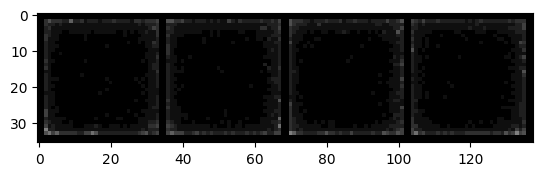

loss: 0.0022, norm: 0.0098, param_norm: 180.5008, vb_loss: 0.0006, ce_loss: 0.5752:   5%|▍         | 88/1875 [00:12<02:20, 12.68it/s] 

nan detected


loss: 0.0020, norm: 0.0009, param_norm: 180.5507, vb_loss: 0.0004, ce_loss: 0.4029:   5%|▌         | 100/1875 [00:13<02:19, 12.77it/s]

nan detected
nan detected
nan detected


loss: 0.0020, norm: 0.0009, param_norm: 180.5507, vb_loss: 0.0004, ce_loss: 0.4029:   6%|▌         | 104/1875 [00:13<02:16, 12.95it/s]

nan detected
nan detected
nan detected


loss: 0.0020, norm: 0.0009, param_norm: 180.5507, vb_loss: 0.0004, ce_loss: 0.4029:   6%|▌         | 106/1875 [00:13<02:16, 12.99it/s]

nan detected
nan detected
nan detected


loss: 0.0020, norm: 0.0062, param_norm: 180.5484, vb_loss: 0.0005, ce_loss: 0.4965:   6%|▌         | 112/1875 [00:14<02:17, 12.86it/s]

nan detected
nan detected
nan detected


loss: 0.0020, norm: 0.0062, param_norm: 180.5484, vb_loss: 0.0005, ce_loss: 0.4965:   6%|▌         | 114/1875 [00:14<02:16, 12.94it/s]

nan detected
nan detected
nan detected


loss: 0.0020, norm: 0.0062, param_norm: 180.5484, vb_loss: 0.0005, ce_loss: 0.4965:   6%|▋         | 118/1875 [00:14<02:14, 13.02it/s]

nan detected
nan detected
nan detected


loss: 0.0020, norm: 0.0023, param_norm: 180.5514, vb_loss: 0.0004, ce_loss: 0.3998:   6%|▋         | 120/1875 [00:14<02:15, 12.96it/s]

nan detected
nan detected


loss: 0.0020, norm: 0.0023, param_norm: 180.5514, vb_loss: 0.0004, ce_loss: 0.3998:   7%|▋         | 124/1875 [00:15<02:14, 12.99it/s]

nan detected
nan detected
nan detected


loss: 0.0020, norm: 0.0023, param_norm: 180.5514, vb_loss: 0.0004, ce_loss: 0.3998:   7%|▋         | 126/1875 [00:15<02:14, 13.00it/s]

nan detected
nan detected
nan detected


loss: 0.0020, norm: 0.0023, param_norm: 180.5514, vb_loss: 0.0004, ce_loss: 0.3998:   7%|▋         | 130/1875 [00:15<02:13, 13.06it/s]

nan detected
nan detected
nan detected


loss: 0.0020, norm: 0.0023, param_norm: 180.5514, vb_loss: 0.0004, ce_loss: 0.3998:   7%|▋         | 132/1875 [00:15<02:13, 13.08it/s]

nan detected
nan detected
nan detected


loss: 0.0020, norm: 0.0023, param_norm: 180.5514, vb_loss: 0.0004, ce_loss: 0.3998:   7%|▋         | 136/1875 [00:16<02:12, 13.09it/s]

nan detected
nan detected
nan detected


loss: 0.0020, norm: 0.0023, param_norm: 180.5514, vb_loss: 0.0004, ce_loss: 0.3998:   7%|▋         | 138/1875 [00:16<02:12, 13.11it/s]

nan detected
nan detected
nan detected


loss: 0.0020, norm: 0.0023, param_norm: 180.5514, vb_loss: 0.0004, ce_loss: 0.3998:   8%|▊         | 142/1875 [00:16<02:12, 13.11it/s]

nan detected
nan detected
nan detected


loss: 0.0020, norm: 0.0023, param_norm: 180.5514, vb_loss: 0.0004, ce_loss: 0.3998:   8%|▊         | 144/1875 [00:16<02:12, 13.11it/s]

nan detected
nan detected
nan detected


loss: 0.0020, norm: 0.0023, param_norm: 180.5514, vb_loss: 0.0004, ce_loss: 0.3998:   8%|▊         | 148/1875 [00:16<02:11, 13.13it/s]

nan detected
nan detected
nan detected


loss: 0.0020, norm: 0.0023, param_norm: 180.5514, vb_loss: 0.0004, ce_loss: 0.3998:   8%|▊         | 150/1875 [00:17<02:11, 13.11it/s]

nan detected
nan detected
nan detected


loss: 0.0020, norm: 0.0023, param_norm: 180.5514, vb_loss: 0.0004, ce_loss: 0.3998:   8%|▊         | 154/1875 [00:17<02:11, 13.13it/s]

nan detected
nan detected
nan detected


loss: 0.0020, norm: 0.0023, param_norm: 180.5514, vb_loss: 0.0004, ce_loss: 0.3998:   8%|▊         | 156/1875 [00:17<02:10, 13.12it/s]

nan detected
nan detected
nan detected


loss: 0.0020, norm: 0.0023, param_norm: 180.5514, vb_loss: 0.0004, ce_loss: 0.3998:   9%|▊         | 160/1875 [00:17<02:10, 13.11it/s]

nan detected
nan detected
nan detected


loss: 0.0020, norm: 0.0023, param_norm: 180.5514, vb_loss: 0.0004, ce_loss: 0.3998:   9%|▊         | 162/1875 [00:18<02:11, 13.05it/s]

nan detected
nan detected
nan detected


loss: 0.0020, norm: 0.0023, param_norm: 180.5514, vb_loss: 0.0004, ce_loss: 0.3998:   9%|▉         | 166/1875 [00:18<02:11, 13.04it/s]

nan detected
nan detected
nan detected


loss: 0.0020, norm: 0.0023, param_norm: 180.5514, vb_loss: 0.0004, ce_loss: 0.3998:   9%|▉         | 168/1875 [00:18<02:11, 12.97it/s]

nan detected
nan detected
nan detected


loss: 0.0020, norm: 0.0023, param_norm: 180.5514, vb_loss: 0.0004, ce_loss: 0.3998:   9%|▉         | 172/1875 [00:18<02:11, 12.99it/s]

nan detected
nan detected
nan detected


loss: 0.0020, norm: 0.0023, param_norm: 180.5514, vb_loss: 0.0004, ce_loss: 0.3998:   9%|▉         | 174/1875 [00:18<02:11, 12.96it/s]

nan detected
nan detected
nan detected


loss: 0.0020, norm: 0.0023, param_norm: 180.5514, vb_loss: 0.0004, ce_loss: 0.3998:   9%|▉         | 178/1875 [00:19<02:10, 12.97it/s]

nan detected
nan detected
nan detected


loss: 0.0020, norm: 0.0023, param_norm: 180.5514, vb_loss: 0.0004, ce_loss: 0.3998:  10%|▉         | 180/1875 [00:19<02:10, 12.95it/s]

nan detected
nan detected
nan detected


loss: 0.0020, norm: 0.0023, param_norm: 180.5514, vb_loss: 0.0004, ce_loss: 0.3998:  10%|▉         | 184/1875 [00:19<02:10, 12.99it/s]

nan detected
nan detected
nan detected


loss: 0.0020, norm: 0.0023, param_norm: 180.5514, vb_loss: 0.0004, ce_loss: 0.3998:  10%|▉         | 186/1875 [00:19<02:09, 13.01it/s]

nan detected
nan detected
nan detected


loss: 0.0020, norm: 0.0023, param_norm: 180.5514, vb_loss: 0.0004, ce_loss: 0.3998:  10%|█         | 190/1875 [00:20<02:09, 13.03it/s]

nan detected
nan detected
nan detected


loss: 0.0020, norm: 0.0023, param_norm: 180.5514, vb_loss: 0.0004, ce_loss: 0.3998:  10%|█         | 192/1875 [00:20<02:08, 13.06it/s]

nan detected
nan detected
nan detected


loss: 0.0020, norm: 0.0023, param_norm: 180.5514, vb_loss: 0.0004, ce_loss: 0.3998:  10%|█         | 193/1875 [00:20<02:58,  9.43it/s]


KeyboardInterrupt: 

In [6]:
d3pm.train()

n_epoch = 10
device = 'cuda'
from torchvision.utils import make_grid
from matplotlib import pyplot as plt
global_step = 0
for i in range(n_epoch):
    d3pm.train()
    pbar = tqdm(dataloader)
    loss_ema = None
    for x, _ in pbar:
        #print(x)
        optim.zero_grad()
        x = x.to(device)
        # discritize x to 10 bins
        x = (x * (N - 2)).long().clamp(0, N - 1)
        
       
        loss, info = d3pm(x)
        
        # if loss.item() > 1000 or torch.isnan(loss):
        #     print(f"loss is too high, skipping, {loss.item()}")
        #     loss.backward()
        #     optim.zero_grad()
        #     continue
        #print(loss.item())
        loss.backward()
        norm = torch.nn.utils.clip_grad_norm_(d3pm.x0_model.parameters(), 0.01)
        # check if gradient has nan, if so, skip
        has_nan = False
        for p in d3pm.x0_model.parameters():
            if torch.isnan(p.grad).any():
                has_nan = True
                print("nan detected")

                optim.zero_grad()
                # reset adam states
                optim = torch.optim.AdamW(d3pm.x0_model.parameters(), lr=1e-4, weight_decay=1e-2, betas=(0.8, 0.9))
                break

        if has_nan:
            continue
      

        with torch.no_grad():
            param_norm = sum([torch.norm(p) for p in d3pm.x0_model.parameters()])
        if loss_ema is None:
            loss_ema = loss.item()
        else:
            loss_ema = 0.99 * loss_ema + 0.01 * loss.item()
        pbar.set_description(f"loss: {loss_ema:.4f}, norm: {norm:.4f}, param_norm: {param_norm:.4f}, vb_loss: {info['vb_loss']:.4f}, ce_loss: {info['ce_loss']:.4f}")
        optim.step()
        global_step += 1

        if global_step % 300 == 1:
            d3pm.eval()

            with torch.no_grad():
                x = d3pm.sample(torch.randint(0, N, (4, 1, 32, 32)).cuda())
                x_as_image = make_grid(x.float() / N, nrow=4)
                plt.figure()
                plt.imshow(x_as_image.permute(1, 2, 0).cpu().numpy())
                plt.show()

            d3pm.train()
                    

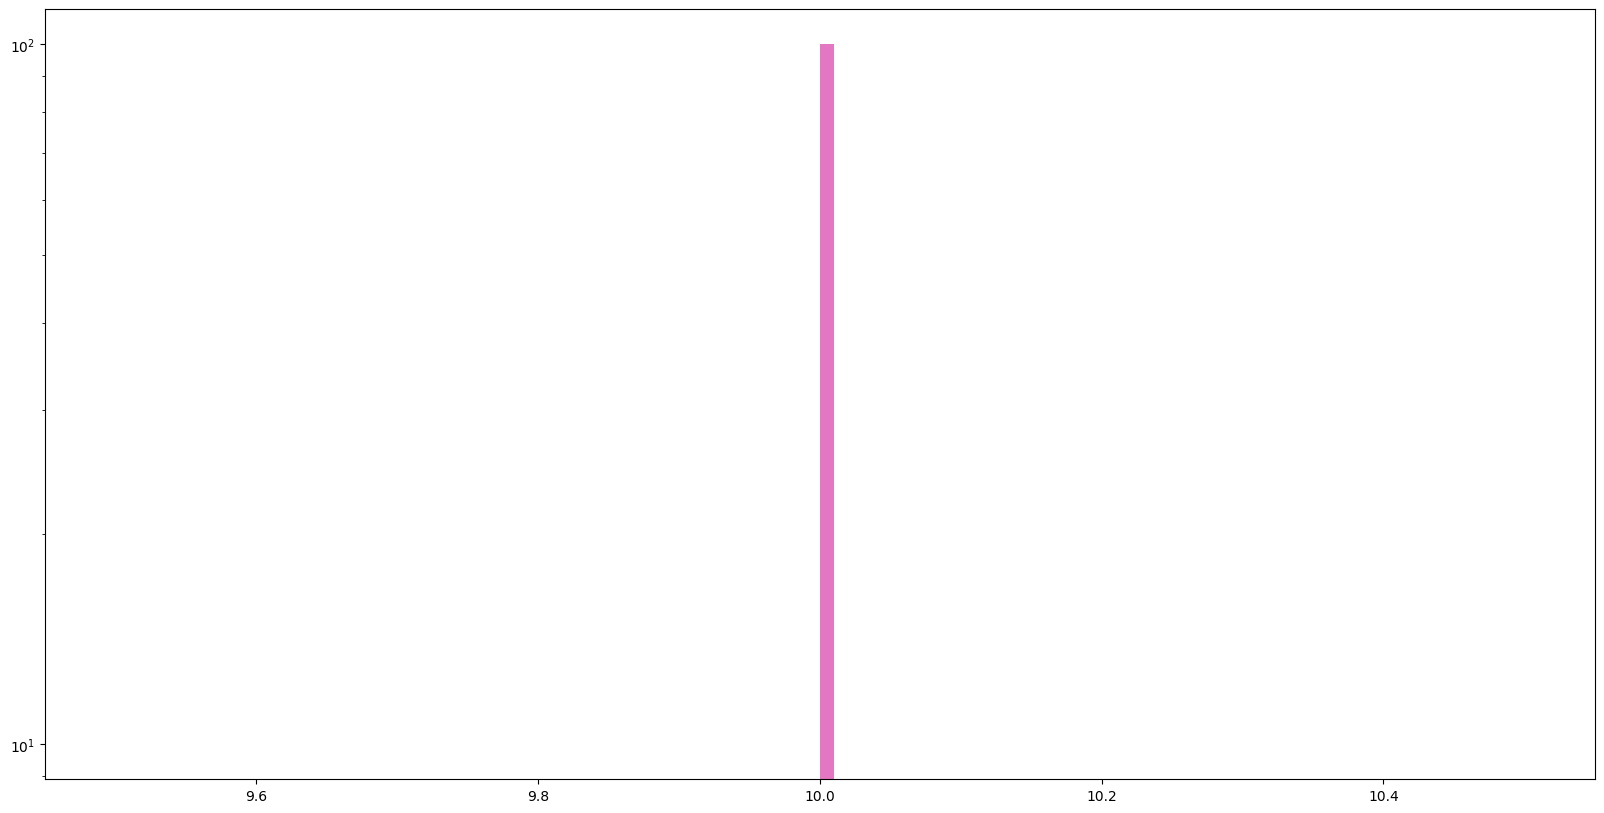

In [ ]:
# check parameter distribution
from matplotlib import pyplot as plt
import numpy as np
def plot_param_dist(model):
    plot_dist = {}
    for name, param in model.named_parameters():
        if param.requires_grad:
            plot_dist[name] = param.detach().cpu().numpy().flatten()
            # sample 1000
            # replace nan with 1000
            plot_dist[name] = np.where(np.isnan(plot_dist[name]), 10, plot_dist[name])
            plot_dist[name] = np.random.choice(plot_dist[name], 1000)
    
    plt.figure(figsize=(20, 10))

    for idx, (name, dist) in enumerate(plot_dist.items()):
    
        plt.hist(dist, bins=100, density=True)
        
    # log y
    plt.yscale('log')

    #plt.legend()
    plt.show()


plot_param_dist(d3pm.x0_model)

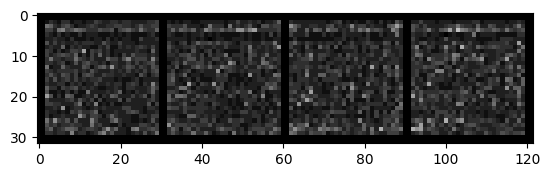

In [27]:
print(d3pm.q_mats[200])

tensor([[0.8116, 0.0126, 0.0126, 0.0126, 0.0126, 0.0126, 0.0126, 0.0126, 0.0126,
         0.0126, 0.0126, 0.0126, 0.0126, 0.0126, 0.0126, 0.0126],
        [0.0126, 0.8116, 0.0126, 0.0126, 0.0126, 0.0126, 0.0126, 0.0126, 0.0126,
         0.0126, 0.0126, 0.0126, 0.0126, 0.0126, 0.0126, 0.0126],
        [0.0126, 0.0126, 0.8116, 0.0126, 0.0126, 0.0126, 0.0126, 0.0126, 0.0126,
         0.0126, 0.0126, 0.0126, 0.0126, 0.0126, 0.0126, 0.0126],
        [0.0126, 0.0126, 0.0126, 0.8116, 0.0126, 0.0126, 0.0126, 0.0126, 0.0126,
         0.0126, 0.0126, 0.0126, 0.0126, 0.0126, 0.0126, 0.0126],
        [0.0126, 0.0126, 0.0126, 0.0126, 0.8116, 0.0126, 0.0126, 0.0126, 0.0126,
         0.0126, 0.0126, 0.0126, 0.0126, 0.0126, 0.0126, 0.0126],
        [0.0126, 0.0126, 0.0126, 0.0126, 0.0126, 0.8116, 0.0126, 0.0126, 0.0126,
         0.0126, 0.0126, 0.0126, 0.0126, 0.0126, 0.0126, 0.0126],
        [0.0126, 0.0126, 0.0126, 0.0126, 0.0126, 0.0126, 0.8116, 0.0126, 0.0126,
         0.0126, 0.0126, 0.0126, 0.01

<Axes: >

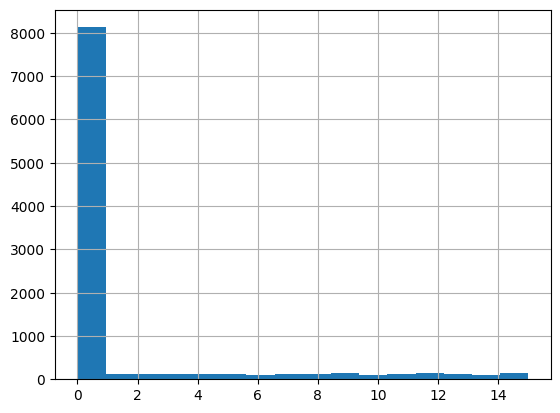

In [25]:

# THIS CHECKS IF Q SAMPLE REALLY SAMPLES from Q.

x = torch.tensor([[0]])
collects = []
for idx in range(10000):
    sample = d3pm.q_sample(x, torch.tensor([200], device = 'cuda:0'), torch.rand((*x.shape, d3pm.num_classses), device='cuda:0'))
    collects.append(sample.item())

# plot histogram
import pandas as pd

df = pd.DataFrame(collects, columns=['sample'])
df['sample'].hist(bins=16)

In [ ]:
qmats = torch.arange(0, 1000).reshape(10, 10, 10)
image_as_pixels = torch.randint(0, 10, (1, 1, 1))
print(image_as_pixels)
qmats[image_as_pixels].shape

In [ ]:
qmats[1, 0, 1]